# Workbook for Processing the P2FA forced alignment
By Katrina Li 2023.4.27

# Outline
1. Check the boundary

    Use `Check_P2FA.praat`

1. Modify the onset-rhyme boudnary, repetitively if needed

    Use `modify_boundaries.praat`

1. Generate the f0 tier

     Use `generate_f0_tier.praat`

1. Extract f0 and duration

    Use `extract_acoustics.py` (cf. InTone_Visualisation)

1. Modify the f0 boundary, repetitivel if needed

    Use `modify_boundaries.praat`

1. Check Visualitaion, mostly f0 data

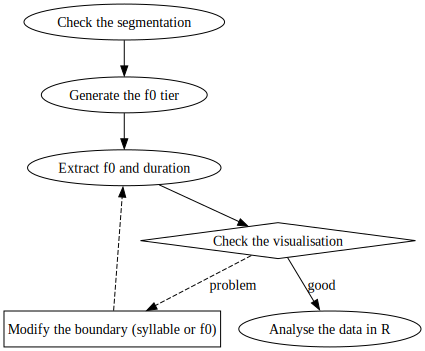

In [11]:
from graphviz import Digraph
dot = Digraph(comment = 'Outline')
dot.node("CheckB","Check the segmentation")
dot.node("Modify","Modify the boundary (syllable or f0)",shape = "box")
dot.node("Generatef0","Generate the f0 tier")
dot.node("Extract","Extract f0 and duration")
dot.node("Check","Check the visualisation",shape = "diamond")
dot.node("Finish","Analyse the data in R")
# connections
dot.edge("CheckB","Generatef0")
dot.edge("Generatef0", "Extract")
# dot.edge("Generatef0", "Modifyf0")
dot.edge("Modify","Extract",style = "dashed")
dot.edge("Extract","Check")
dot.edge("Check","Finish",label = "good")
dot.edge("Check","Modify",label = "problem", style = "dashed")
dot

# Prerequisite

Establish appropriate folder structure for each langauge. My folder structure is shown below. Note that the subfolders are created for intermediate stages.

```
workflow/
├── sound_original/
│   └── S9dia2nDT4.wav
├── textgrid_original/
│   ├── discard/
│   ├── later/
│   ├── processed/
│   └── S10dia1B2_checked.TextGrid
├── textgrid_checked/
│   ├── modify/
│   └── processed/
├── p2falog/
│   └── S9dia2nDT4_log.txt
└── textgrid_pitch_batch/
    ├── discard/
    ├── modify/
    ├── S10dia1B2.PointProcess
    └── S10dia1B2_checked.TextGrid
```

# Process

##  Check the segmentation (syllable level)

In this step, we check the segmentation returned from the P2FA forced alignment.

Run the praat script `checkP2FA.praat`. This praat script will go through each boundary at onset/rhyme boundary, allowing you to accept the automatic marking or assign a new boundary.

- Input: `textgrid_original/XXX.wav.Textgrid` files, and the associated wav files in `sound_original` folder.

- Output: `textgrid_checked/XXX_checked.Textgrid` files with generated rhyme + syllable tier. The original files will be moved into `textgrid_original/processed` subfolder.

For mac system, I recommended to combine with the use of App BetterTouchTool, so that you can specify short cut for the buttons of the scripts.

After finishing checking the files, remember to move all the files into `textgrid_original/processed` folder.

## Modify the boundary (f0 or syllable)

There are two ways to organise the modify process.

1. Put the files in the `/modify` folder, which can either be in `textgrid_checked` folder to modify onset-syllable boundarieds), or in `textgrid_pitch_batch` folder to modify the f0 boundaries.

    Run the praat script `modify_boundaries.praat`, the go through the files in a folder

2. Use `open_target_files` to open individual file in either `textgrid_checked` or `textgrid_pitch_batch`, and then manually saved to the same place

### A handy script: Move selected files
1. In the `textgrid_original` folder, move files to unprocessed, so that some TextGrid will be processed later; Or more commonly, move all the files to `unprocessed` foler, and move files to be annotated out of thefolder. The code below demonstrates this purpose.

In [4]:
# Prerequisite
import os
from pathlib import Path
import shutil
import re

current_lang = "Cantonese"
dir = os.path.join("/Users/kechun/Documents/0_PhD_working_folder", str(current_lang), "workflow")

######################## In checking the P2FA step#####################
# directory = os.path.join(dir, "textgrid_original/unprocessed")
# destination = os.path.join(dir, "textgrid_original")
######################## In checking the pitch boundary step#####################
directory = os.path.join(dir, "textgrid_pitch_batch")
destination = os.path.join(dir, "textgrid_pitch_batch/modify")

targetsentence = ["AT"]
targetfocus = ["1","2","3","4"]
# targetid = ["S15"]
for ifile in os.listdir(directory):
    if ifile.endswith(".TextGrid"):
        filename = ifile.split(".")[0]
        parid = re.split("diaN?1?",filename)[0]
        condition = re.split("diaN?1?",filename)[1]
        tone = re.search("[A-F]T?",condition).group(0)
        focus = re.search("[1-5]a?",condition).group(0)
        if tone in targetsentence and focus in targetfocus:
            shutil.move(os.path.join(directory,ifile), destination)

2. For Condition4 files, we need an extra step of processing. We want to exclude the first part of the sentence so that our cheking workload can be reduced. 

    Move files from `/unprocessed` to `/old4`, then run the praat script `cut_condition4.praat`. After this, you will have the files saved to `textgrid_original` folder. You can follow the previosu steps.

    Do remember to move the cutted files from `old4` to `old4/processed`.

## Generate the f0 tier
After checking the segmentation boudnaries, the next step is the modify the 'rhyme' tier to make it fit for f0 extraction.
The code below will call the praat script `generate_f0_tier.praat`, replace the original rhyme tier with a f0 tiers, where initial and ending periods where no f0 is dectected are deleted.

- Input: `/textgrid_check/XX_checked.TextGrid` files. Remember to change the langauge in the code below.

- Output: `textgrid_pitch_batch/XX_checked.TextGrid` files. The original files will be moved into the subfolder `/textgrid_check/processed`.


The current design is to iterate over the entire folder. Calling praat subprocessed does not seem a very elegant solution, however, the advange is that it can be combined with python function of moving processed files into another folders. When errors arise, we can know which file causes problem, adjust accordingly and continue with the rest files.
The alternative way is to ask users to specify the desired processing file (commented code). But when there are too many files, this does not become economical.

In either case, the idea is to avoid repetitive generation of this tier, as later on these files may be adjusted manually and we do not want to overwrite them.

In [5]:
# This file will read specified files, and run the praat script
import subprocess
from itertools import product
import os
import shutil
import parselmouth
from parselmouth.praat import call
import math

################## Change the language###############
current_lang = "Cantonese"
dir = os.path.join("/Users/kechun/Documents/0_PhD_working_folder", str(current_lang), "workflow")
directory = os.path.join(dir, "textgrid_checked")
destination = os.path.join(dir, "textgrid_checked/processed")
# Open the sound
directory_sound = os.path.join(dir, "sound_original")

# par = ["S3",]
# dia = ["dia1", "dia1n"]
# sentence = ["A","B","C","D","E","F","I","AT","DT"]
# focus = ["1","2","3","4"]
# element_list = list(product(par,dia,sentence,focus))

# Argument to the script
# The first three is to call the app and script
# Arg1: filename
# Arg2: textgriddir
# Arg3: sounddir
# Arg2: f0min (if 0, then the default two-pass pitch range calculation will be used)
# Arg3: f0max (if 0, then the default two-pass pitch range calculatio will be used)
# Other variables like file directory, the tiers can be modified
# Output: the updated f0 
for ifile in os.listdir(directory):
    if ifile.endswith(".TextGrid"):
        basename = ifile[:-17]
        filename = basename + "_checked"
# # for element in element_list:
# #     fullname = ''.join(element)
# #     filename = fullname + "_checked"
    # Open the sound
        soundname = os.path.join(directory_sound, basename + ".wav")
        sound = parselmouth.Sound(soundname)
        # Calculate the best f0
        # The first pass
        pitch1 = call(sound, "To Pitch", 0.0, 50, 800)
        min1 = call(pitch1, "Get minimum", 0, 0, "Hertz", "None")
        max1 = call(pitch1, "Get maximum", 0, 0, "Hertz", "None")
        q1 = call(pitch1, "Get quantile", 0, 0, 0.25, "Hertz")
        q3 = call(pitch1, "Get quantile", 0, 0, 0.75, "Hertz")
        q1 = math.floor(q1)
        q3 = math.ceil(q3)
        # The second pass
        defaultf0floor = math.floor((0.7 * q1)/ 10) * 10
        defaultf0ceiling = math.ceil((2.5 * q3)/ 10) * 10
        # Run the script, not send, 
        subprocess.call(["/Applications/Praat.app/Contents/MacOS/Praat", "--run", "scripts_praat/generate_f0_tier.praat", filename, directory, directory_sound, str(defaultf0floor),str(defaultf0ceiling)])
        path = filename + ".TextGrid"
        shutil.move(os.path.join(directory,path), destination)

## Extract f0 and duration

Open the script `extract_acoustics.py`, and specify the relevant parameters (e.g. the langauge to work on). This will extract needed parameters that are easy to analyse.

- Input: `textgrid_pitch_batch/XXX.TextGrid` files, associated `PointProcess` or `Pitch` files if there are any. Also, a `Template.xlsx` provides the template of read speech to be able to compared to.

- Output: `extract_acoustics_results/230530Cantonese_data.tsv` and `extract_acoustics_results/230530Cantonese_realf0_data.tsv`

This script mainly makes use of the python package Parselmouth, and also relies on a prespecified template of the materials.

In [10]:
%run extract_acoustics.py

Empty DataFrame
Columns: [self, other]
Index: []
Empty DataFrame
Columns: [self, other]
Index: []
Number of files processed:  922
REP dictionary
啊	7
哦	5
阿	1
ADD dictionary
spp	152
spg	124
好	105
一	51
定	51
呢	33
嘅	30
今	26
晚	26
饭	26
餸	26
食	26
出	25
戏	25
睇	25
我	10
哋	10
仲	10
係	8
谂	7
下	7
啦	7
你	6
點	6
解	6
开	6
部	6
旧	6
车	6
其	4
他	4
方	4
案	4
紧	4
依	3
家	3
生	3
意	3
咁	3
做	3
咩	3
先	3
得	3
嗰	3
五	3
十	3
几	3
分	3
真	3
丢	3
贾	3
都	3
可	3
以	3
留	3
学	3
事	3
啊	2
至	2
个	1
情	1
唔	1
咯	0
SFP dictionary
咯	4


## Check visualisation

Step I.

Open `InTone_Visualisation.Rproj`. 

Open `Rcode_f0check/01f0clean.Rmd` and specify the data files to be read in (because the datafiles have date on it).

- Input: the generated datafiles in `extract_acoustics_results`

- Output: `X_flagfiles.csv` which contains all the files to check, and the visualisation of pitch contours in the folder `03figures`.

Step II.

Use *Python* script below to move all the files into the `textgrid_pitch_batch/modify` folder, along with their pointprocess files (if not, then generate one). It is often needed to modify pointprocess files to correct the pitch.

In [2]:
# Move the textgrid files to modify folder
# Prerequisite
import os
from pathlib import Path
import shutil
import re
import pandas as pd
import parselmouth
from parselmouth.praat import call

#################################################
# read the flagfile csv
# flagfiles = pd.read_csv("Rcode_f0check/Can_flagfiles.csv")
flagfiles = pd.read_csv("Rcode_analysis/Cantonese_dur_outliers.csv")
#################################################

current_lang = "Cantonese"
dir = os.path.join("/Users/kechun/Documents/0_PhD_working_folder", str(current_lang), "workflow")
directory = os.path.join(dir, "textgrid_pitch_batch")
destination = os.path.join(dir, "textgrid_pitch_batch/modify")
sounddirectory = os.path.join(dir,"sound_original")

for index,row in flagfiles.iterrows():
    file_to_move = row["filename"]
    filename = file_to_move + "_checked.TextGrid"
    # print(filename)
    # Read sound files
    soundname = file_to_move + ".wav"
    sound = parselmouth.Sound(os.path.join(sounddirectory,soundname))
    #Check if pointprocess exists
    pointprocess = os.path.join(directory,file_to_move + ".PointProcess")
    pitch = os.path.join(directory,file_to_move + ".Pitch")
    if os.path.exists(pitch):
        shutil.move(pitch,destination)
    if os.path.exists(pointprocess):
        shutil.move(pointprocess,destination)
    else:
        # Read the default f0 floor and ceilling
        defaultf0floor = row["defaultf0floor"]
        defaultf0ceiling = row["defaultf0ceiling"]
        # generate PointProcesses files
        pointprocess = call(sound, "To PointProcess (periodic, cc)", defaultf0floor,defaultf0ceiling)
        # Save the pointproces file into the modify folder
        pointprocess.save(os.path.join(destination,file_to_move + ".PointProcess"))
    shutil.move(os.path.join(directory,filename), destination)

Step III.

I will move all files back to the `textgrid_pitch_batch` folder, and rerun the `extract_acoustics.py` and the `Rcode_f0check/01f0clean.Rmd`. This is because using the pointprocesses files might result in new pitch parameters.

Step IV.

Run the `modify_boundaries.praat` to modify the boundaries.

Note:
S1dia1nC2: duk very limited f0;
S1dia1nI3: fan get creaky; the best pitch range might not be enough; need to generate pitch files!

S1dia1nF2: 影  might just be curly.

S1dia2nDT1: on need to generate pitch files, but couldn't finish this process
S1dia2nDT2: the default pitch range seems OK, but why errors?


In final data:
delte S1dia1nF2_7, too much curly


In [90]:
# Read the flagfiles
import pandas as pd
flagfiles = pd.read_csv("f0_check/Can_flagfiles.csv")
target = "S3dia1nC4"

print(flagfiles[flagfiles["filename"] == target])


      filename chars  defaultf0floor  defaultf0ceiling
261  S3dia1nC4  国, 读             140               670


## 